In [23]:
import os

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np

import seaborn as sns

from oia.utils import load_config, get_axes, plot_basemap, scale_bar, plot_basemap_labels, save_fig

data_path = os.path.join('..','Data')

In [24]:
ind_mapper = pd.read_excel(os.path.join(data_path,'economic_IO_tables','input','sh_cou_06_16.xls'),
                          sheet_name='ind_mapper',header=None)
ind_mapper = dict(zip(ind_mapper[0],ind_mapper[1]))

com_mapper = pd.read_excel(os.path.join(data_path,'economic_IO_tables','input','sh_cou_06_16.xls'),
                          sheet_name='com_mapper',header=None)
com_mapper = dict(zip(com_mapper[0],['P_'+x for x in com_mapper[1]]))

reg_mapper = pd.read_excel(os.path.join(data_path,'economic_IO_tables','input','sh_cou_06_16.xls'),
                          sheet_name='reg_mapper',header=None)
reg_mapper = dict(zip(reg_mapper[0], reg_mapper[1]))

sectors = [chr(i) for i in range(ord('A'),ord('P')+1)]

### Load MRIO

In [25]:
MRIO = pd.read_csv(os.path.join(data_path,'economic_IO_tables','output','mrio_argentina.csv'),index_col=[0,1],header=[0,1])

### Load provincial data

In [26]:
prov_data = pd.read_excel(os.path.join(data_path,'economic_IO_tables','input','PIB_provincial_06_17.xls'),sheet_name='VBP',
                         skiprows=3,index_col=[0],header=[0],nrows=71)
prov_data = prov_data.loc[[x.isupper() for x in prov_data.index],:]
prov_data.columns = ['Ciudad de Buenos Aires', 'Buenos Aires', 'Catamarca', 'Cordoba',
       'Corrientes', 'Chaco', 'Chubut', 'Entre Rios', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquen', 'Rio Negro',
       'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe',
       'Santiago del Estero', 'Tucuman', 'Tierra del Fuego',
       'No distribuido', 'Total']
region_names = list(prov_data.columns)[:-2]

### Load OD data

In [27]:
od_matrix_total = pd.DataFrame(pd.read_excel(os.path.join(data_path,'OD_data','province_ods.xlsx'),
                          sheet_name='total',index_col=[0,1],usecols =[0,1,2,3,4,5,6,7])).unstack(1).fillna(0)
od_matrix_total.columns.set_levels(['A','G','C','D','B','I'],level=0,inplace=True)
od_matrix_total.index = od_matrix_total.index.map(reg_mapper)
od_matrix_total = od_matrix_total.stack(0)
od_matrix_total.columns = od_matrix_total.columns.map(reg_mapper)
od_matrix_total = od_matrix_total.swaplevel(i=-2, j=-1, axis=0)

### Compare MRIO with provincial data

In [28]:
od_share = pd.DataFrame((od_matrix_total.sum(axis=0,level=1).sum())/od_matrix_total.sum(axis=0,level=1).sum().sum(),
                        columns=['od'])*100

In [29]:
mrio_share = pd.DataFrame(MRIO.sum(level=0,axis=0).sum(1)[:24]/(MRIO.sum(level=0,axis=0).sum(1)[:24].sum(0)),
                                                  columns=['mrio'])[:24]*100

In [30]:
prov_share = pd.DataFrame(prov_data.sum(axis=0)[:24]/(prov_data.sum(axis=0)[:24].sum()),
                                                  columns=['prov'])*100

In [31]:
all_shares = pd.concat([od_share,mrio_share,prov_share],axis=1,sort=True).fillna(0)

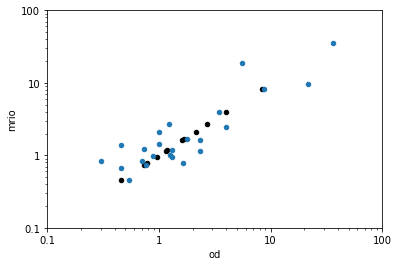

In [32]:
fig,ax = plt.subplots(1,1)
all_shares.plot.scatter(x='prov',y='mrio',ax=ax,color='black')
all_shares.plot.scatter(x='od',y='mrio',ax=ax)

ax.axis([0.1, 100, 0.1, 100])
ax.loglog()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

In [33]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    import scipy.stats
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [37]:
rsquared(np.array(all_shares['mrio']),np.array(all_shares['od']))

0.8143579615080124

### Load provincial shapefile

In [35]:
prov_zones = gpd.read_file(os.path.join(data_path,'boundaries','admin_1_boundaries.shp'))
ctry_zones = gpd.read_file(os.path.join(data_path,'boundaries','admin_0_boundaries.shp'))
prov_zones.name = prov_zones.name.apply(lambda x : reg_mapper[x])
prov_zones = prov_zones.merge(all_shares,left_on='name',right_index=True)

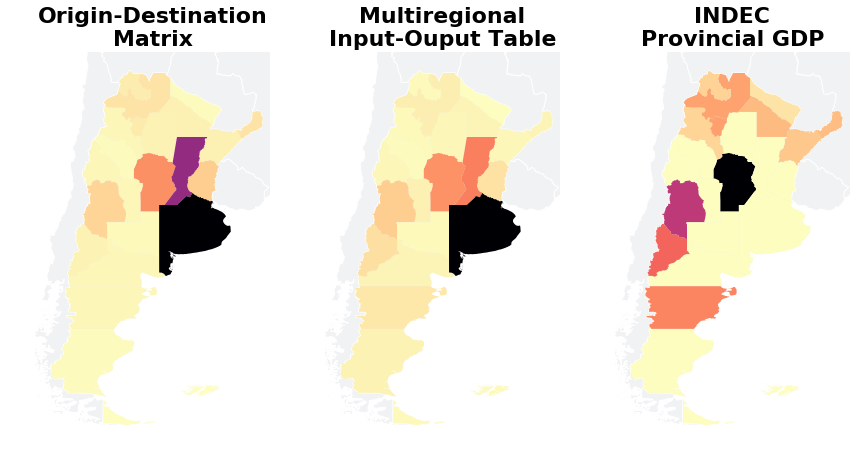

In [36]:
fig,axes =  plt.subplots(1,3,figsize=(12,24))

variants = ['od','mrio','prov']
variant_names = ['Origin-Destination\nMatrix','Multiregional\nInput-Ouput Table','INDEC\nProvincial GDP']

for iter_,ax in enumerate(axes.flat):
    
    prov_zones = prov_zones.cx[-70:-55, -60:-20]
    ctry_zones = ctry_zones.cx[-70:-55, -60:-20]
    ctry_zones.plot(ax=ax,edgecolor='white',color='#f1f2f4')
    prov_zones.plot(column=variants[iter_],ax=ax,cmap='magma_r')

    ax.set_ylim(-55,-20)
    ax.set_xlim(-75,-53)
    ax.set_title(variant_names[iter_],fontweight='bold',fontsize=22)
    ax.set_axis_off()
    
fig.tight_layout()
fig.savefig(os.path.join(data_path,'..','figures','mrio_comparison_figure.png'),dpi=300)

In [20]:
prov_zones

,name,geometry,od,mrio,prov
0,Misiones,(POLYGON ((-56.00300054699994 -27.337085269999...,2.338864,1.156557,1.156461
1,San_Luis,POLYGON ((-67.0554701129999 -31.85605263599996...,0.992482,1.412405,0.000000
2,San_Juan,POLYGON ((-69.61058639299995 -28.4139038699999...,0.892403,0.990568,0.000000
3,Entre_Rios,POLYGON ((-57.80919877899993 -30.7296225119999...,4.016226,2.485332,0.000000
4,Santa_Cruz,(POLYGON ((-69.41580963099995 -51.089576720999...,0.457906,1.398365,0.000000
5,Rio_Negro,(POLYGON ((-64.76547241199995 -40.783512114999...,0.741905,1.230621,0.000000
6,Chubut,(POLYGON ((-66.6985168459999 -45.2474746699999...,0.997422,2.127789,2.127612
7,Cordoba,POLYGON ((-63.43226892399991 -29.7595532989999...,8.724105,8.316015,8.315323
8,Mendoza,POLYGON ((-69.12569695099995 -32.0028349849999...,3.467330,4.008085,4.007752
9,La_Rioja,POLYGON ((-68.52082545399992 -27.8198800829999...,0.457880,0.670247,0.000000


In [17]:
# plot on heatmap

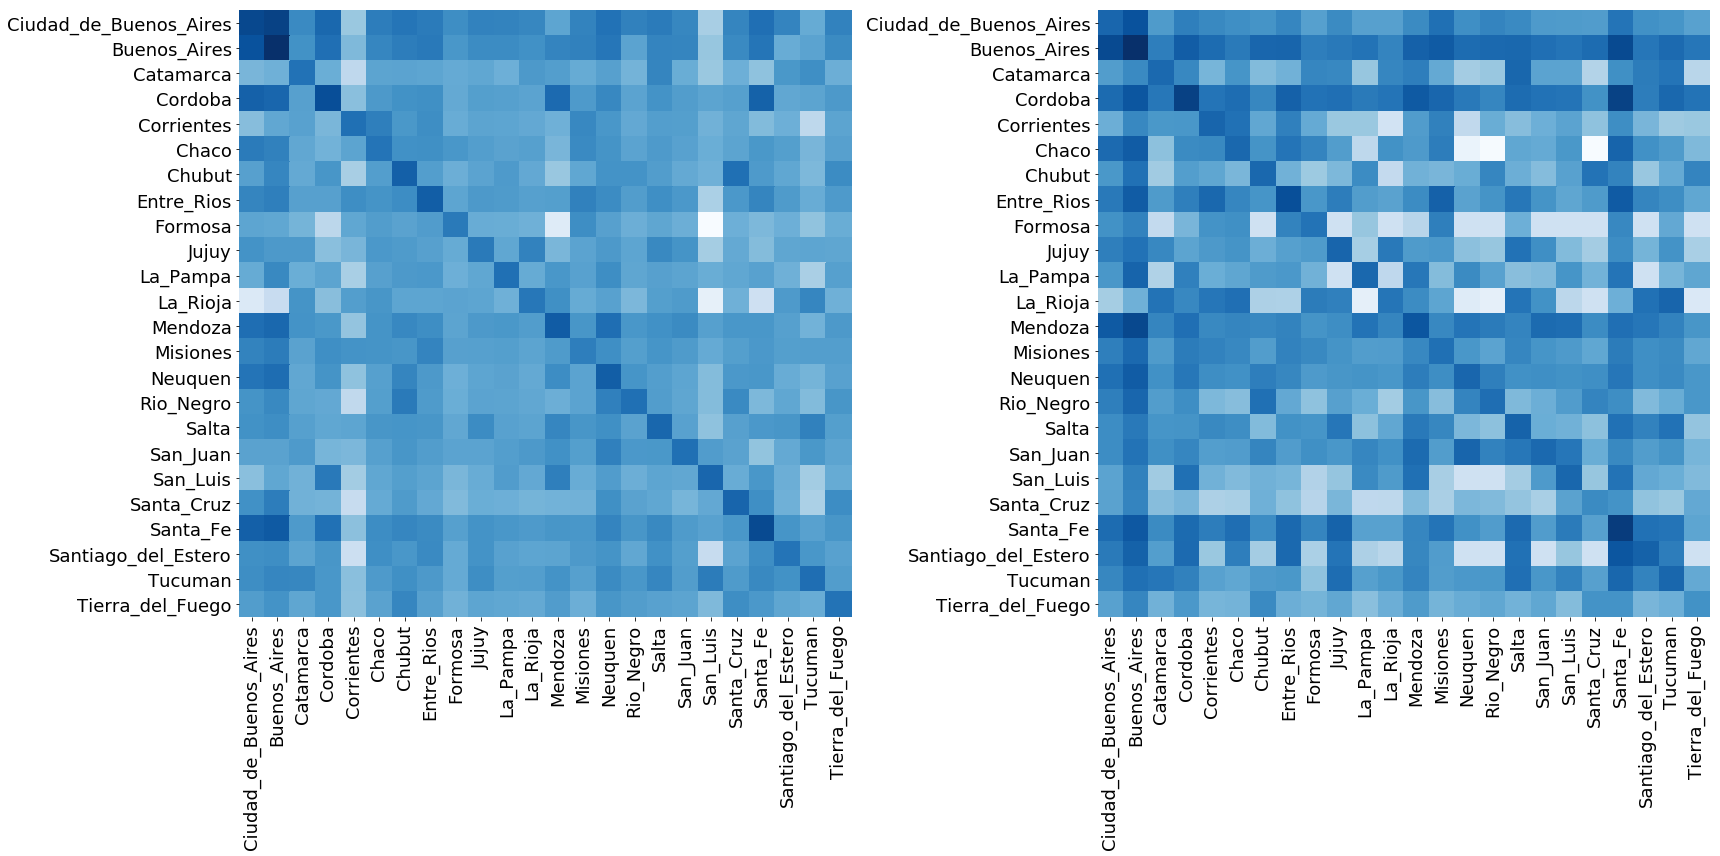

In [17]:
from matplotlib.colors import LogNorm
import math

fig,axes =  plt.subplots(1,2,figsize=(24,12))

for iter_,ax in enumerate(axes.flat):
    if iter_ == 0:
        mrio_sum =MRIO.sum(level=0,axis=0).sum(level=0,axis=1)[:24]
        
        mrio_sum= mrio_sum.replace(0,1e-5)

        data= np.array(mrio_sum)
        log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
        cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

        sns.heatmap(
            data=mrio_sum,
            norm=log_norm,cmap='Blues',ax=ax,cbar_kws={"ticks": cbar_ticks},cbar=False)
    elif iter_ == 1:
        od = od_matrix_total.sum(level=1,axis=0).sum(level=0,axis=1)/1e6
        od = od.reindex(mrio_sum.index)
        od = od[list(mrio_sum.columns)]
        od = od.replace(0,1e-5)
        data= np.array(od)
        log_norm = LogNorm(vmin=data.min().min(), vmax=data.max().max())
        cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), 1+math.ceil(math.log10(data.max().max())))]

        sns.heatmap(
            data=od,
            norm=log_norm,cmap='Blues',ax=ax,cbar_kws={"ticks": cbar_ticks},cbar=False)
        
    ax.tick_params(axis = 'both',labelsize=18,labelcolor='black',color='black')
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.tight_layout()

fig.savefig(os.path.join(data_path,'..','figures','heatmap.png'),dpi=300)